# CCA

In [1]:
import numpy as np
import sbi
from sbi.inference import SNPE
import getdist
from getdist import plots, MCSamples
import sys, pathlib, os, random
import torch
import matplotlib.pyplot as plt
import scipy.stats as stats

2024-11-22 10:46:30.741288: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:485] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-11-22 10:46:30.756834: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:8454] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-11-22 10:46:30.761603: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1452] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-11-22 10:46:30.775477: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-11-22 10:46:32.009397: W tensorflow/compiler/tf2

# Load compressed dv and true paramters

In [2]:
cca_file = np.load('/pscratch/sd/m/minsu98/shared_KZ/compressed_by_cca.pkl',allow_pickle=True)

In [3]:
compressed_dv_sims = cca_file['WL_23_WPH_short_CMBWL']['DV']
compressed_dv_labels = cca_file['WL_23_WPH_short_CMBWL']['params']

compressed_dv_fid  = cca_file['WL_23_WPH_short_CMBWL']['target']

compressed_dv_fid = compressed_dv_fid.reshape(-1,1).T

In [4]:
# Only infer Omm and S8

compressed_dv_labels = compressed_dv_labels[:,0:2]


In [5]:
# test
compressed_dv_fid.shape, compressed_dv_labels.shape, compressed_dv_sims.shape

((1, 16), (8187, 2), (8187, 16))

In [6]:
def get_posterior_MCSamples(N_rel, compressed_dv_fid, compressed_dv_sims, compressed_dv_labels):
    gd_samples = []


    for _ in range(N_rel):
        # define compressed data, parameters, and target (compressed)
        x0 = compressed_dv_fid
        p, l = compressed_dv_sims, compressed_dv_labels


        prior = sbi.utils.BoxUniform(low=torch.tensor(np.min(l, axis=0)), \
            high=torch.tensor(np.max(l, axis=0)))
        inference = SNPE(prior=prior, density_estimator=sbi.utils.posterior_nn(\
                        model='maf', hidden_features=50, num_transforms=4))
        theta, x = torch.tensor(l).float(), torch.tensor(p).float()
        density_estimator = inference.append_simulations(theta, x).train()
        posterior = inference.build_posterior(density_estimator)

        samples = posterior.sample((10000,), x=x0)

        # # all 3
        # gd_samples.append(MCSamples(samples=samples.numpy(), names=['Om', 'S8', 'A_IA'], \
        #     labels=['Om', 'S8', r'A_{IA}'], ranges={"Om": [np.min(l[:, 0]), np.max(l[:, 0])], \
        #         "S8": [np.min(l[:, 1]), np.max(l[:, 1])], "A_IA": [np.min(l[:, 2]), np.max(l[:, 2])]},\
        #         label='test'))
        
        # Om and S8
        gd_samples.append(MCSamples(samples=samples.numpy(), names=['Om', 'S8'], \
            labels=['Om', 'S8'], ranges={"Om": [np.min(l[:, 0]), np.max(l[:, 0])], \
                "S8": [np.min(l[:, 1]), np.max(l[:, 1])]},\
                label='test',\
                settings={'smooth_scale_2D':0.45, 'smooth_scale_1D':0.45}))
    return gd_samples

In [7]:
gd_samples_list = get_posterior_MCSamples(5, compressed_dv_fid, compressed_dv_sims, compressed_dv_labels)

/tmp/ipykernel_242610/3272933811.py:13: DeprecationWarning: This method is deprecated and will be removed in a future release.Please use `from sbi.neural_nets import posterior_nn` in the future.
  inference = SNPE(prior=prior, density_estimator=sbi.utils.posterior_nn(\


 Neural network successfully converged after 55 epochs.

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

Removed no burn in


/tmp/ipykernel_242610/3272933811.py:13: DeprecationWarning: This method is deprecated and will be removed in a future release.Please use `from sbi.neural_nets import posterior_nn` in the future.
  inference = SNPE(prior=prior, density_estimator=sbi.utils.posterior_nn(\


 Neural network successfully converged after 59 epochs.

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

Removed no burn in
 Neural network successfully converged after 57 epochs.

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

Removed no burn in
 Neural network successfully converged after 73 epochs.

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

Removed no burn in
 Neural network successfully converged after 70 epochs.

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

Removed no burn in


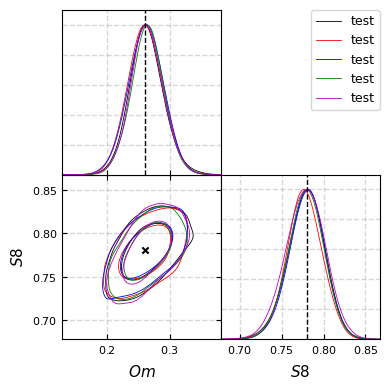

In [8]:
%matplotlib inline 

g = plots.get_subplot_plotter()
g.triangle_plot(gd_samples_list, filled=False)

true = [0.26, 0.78, 0.5]

# add truth values to get subplot
for i in range(2):
    for j in range(2):
        if j > i:
            continue
        ax = g.subplots[i, j]
        if i == j:
            ax.axvline(true[i], color="black", ls="--", lw=1)
        else:
            ax.scatter(true[j], true[i], color="black", marker="x", s=20) 
        ax.grid(True, ls="--", lw=1, alpha=0.5)

In [9]:
cov_mat_list = []

for i in range(len(gd_samples_list)):
    cov_mat_list.append(gd_samples_list[i].getCovMat().matrix)

In [10]:
FoM_list = []
for i in range(len(gd_samples_list)):
    FoM_list.append(1./np.sqrt(np.linalg.det(cov_mat_list[i])))
    print(f'FoM in test {i} is {FoM_list[i]}')
    
FoM_list = np.array(FoM_list)

print('mean FoM is ', np.mean(FoM_list))

FoM in test 0 is 1943.110669316424
FoM in test 1 is 1952.7854409858755
FoM in test 2 is 2003.9814361226836
FoM in test 3 is 2104.8783558304785
FoM in test 4 is 1957.9113370501939
mean FoM is  1992.5334478611312


# make the NDE smaller (num_transforms=3)

In [11]:
def get_posterior_MCSamples(N_rel, compressed_dv_fid, compressed_dv_sims, compressed_dv_labels):
    gd_samples = []


    for _ in range(N_rel):
        # define compressed data, parameters, and target (compressed)
        x0 = compressed_dv_fid
        p, l = compressed_dv_sims, compressed_dv_labels


        prior = sbi.utils.BoxUniform(low=torch.tensor(np.min(l, axis=0)), \
            high=torch.tensor(np.max(l, axis=0)))
        inference = SNPE(prior=prior, density_estimator=sbi.utils.posterior_nn(\
                        model='maf', hidden_features=50, num_transforms=3))
        theta, x = torch.tensor(l).float(), torch.tensor(p).float()
        density_estimator = inference.append_simulations(theta, x).train()
        posterior = inference.build_posterior(density_estimator)

        samples = posterior.sample((10000,), x=x0)

        # # all 3
        # gd_samples.append(MCSamples(samples=samples.numpy(), names=['Om', 'S8', 'A_IA'], \
        #     labels=['Om', 'S8', r'A_{IA}'], ranges={"Om": [np.min(l[:, 0]), np.max(l[:, 0])], \
        #         "S8": [np.min(l[:, 1]), np.max(l[:, 1])], "A_IA": [np.min(l[:, 2]), np.max(l[:, 2])]},\
        #         label='test'))
        
        # Om and S8
        gd_samples.append(MCSamples(samples=samples.numpy(), names=['Om', 'S8'], \
            labels=['Om', 'S8'], ranges={"Om": [np.min(l[:, 0]), np.max(l[:, 0])], \
                "S8": [np.min(l[:, 1]), np.max(l[:, 1])]},\
                label='test',\
                settings={'smooth_scale_2D':0.45, 'smooth_scale_1D':0.45}))
    return gd_samples

In [12]:
gd_samples_list = get_posterior_MCSamples(5, compressed_dv_fid, compressed_dv_sims, compressed_dv_labels)

/tmp/ipykernel_242610/586695301.py:13: DeprecationWarning: This method is deprecated and will be removed in a future release.Please use `from sbi.neural_nets import posterior_nn` in the future.
  inference = SNPE(prior=prior, density_estimator=sbi.utils.posterior_nn(\


 Neural network successfully converged after 60 epochs.

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

Removed no burn in
 Neural network successfully converged after 80 epochs.

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

Removed no burn in
 Neural network successfully converged after 64 epochs.

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

Removed no burn in
 Neural network successfully converged after 48 epochs.

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

Removed no burn in
 Neural network successfully converged after 69 epochs.

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

Removed no burn in


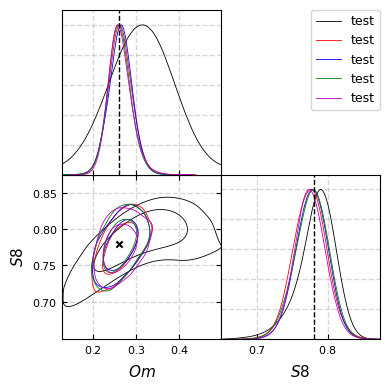

In [13]:
%matplotlib inline 

g = plots.get_subplot_plotter()
g.triangle_plot(gd_samples_list, filled=False)

true = [0.26, 0.78, 0.5]

# add truth values to get subplot
for i in range(2):
    for j in range(2):
        if j > i:
            continue
        ax = g.subplots[i, j]
        if i == j:
            ax.axvline(true[i], color="black", ls="--", lw=1)
        else:
            ax.scatter(true[j], true[i], color="black", marker="x", s=20) 
        ax.grid(True, ls="--", lw=1, alpha=0.5)

In [14]:
cov_mat_list = []

for i in range(len(gd_samples_list)):
    cov_mat_list.append(gd_samples_list[i].getCovMat().matrix)
    
FoM_list = []
for i in range(len(gd_samples_list)):
    FoM_list.append(1./np.sqrt(np.linalg.det(cov_mat_list[i])))
    print(f'FoM in test {i} is {FoM_list[i]}')
    
FoM_list = np.array(FoM_list)

print('mean FoM is ', np.mean(FoM_list))

FoM in test 0 is 624.9409299405136
FoM in test 1 is 1868.195579007212
FoM in test 2 is 1892.3907650735189
FoM in test 3 is 1797.5839525035274
FoM in test 4 is 1781.6199816093817
mean FoM is  1592.9462416268307


# Make NDE more complicated

In [18]:
def get_posterior_MCSamples(N_rel, compressed_dv_fid, compressed_dv_sims, compressed_dv_labels):
    gd_samples = []


    for _ in range(N_rel):
        # define compressed data, parameters, and target (compressed)
        x0 = compressed_dv_fid
        p, l = compressed_dv_sims, compressed_dv_labels


        prior = sbi.utils.BoxUniform(low=torch.tensor(np.min(l, axis=0)), \
            high=torch.tensor(np.max(l, axis=0)))
        inference = SNPE(prior=prior, density_estimator=sbi.utils.posterior_nn(\
                        model='maf', hidden_features=50, num_transforms=6))
        theta, x = torch.tensor(l).float(), torch.tensor(p).float()
        density_estimator = inference.append_simulations(theta, x).train()
        posterior = inference.build_posterior(density_estimator)

        samples = posterior.sample((10000,), x=x0)

        # # all 3
        # gd_samples.append(MCSamples(samples=samples.numpy(), names=['Om', 'S8', 'A_IA'], \
        #     labels=['Om', 'S8', r'A_{IA}'], ranges={"Om": [np.min(l[:, 0]), np.max(l[:, 0])], \
        #         "S8": [np.min(l[:, 1]), np.max(l[:, 1])], "A_IA": [np.min(l[:, 2]), np.max(l[:, 2])]},\
        #         label='test'))
        
        # Om and S8
        gd_samples.append(MCSamples(samples=samples.numpy(), names=['Om', 'S8'], \
            labels=['Om', 'S8'], ranges={"Om": [np.min(l[:, 0]), np.max(l[:, 0])], \
                "S8": [np.min(l[:, 1]), np.max(l[:, 1])]},\
                label='test',\
                settings={'smooth_scale_2D':0.45, 'smooth_scale_1D':0.45}))
    return gd_samples

In [19]:
gd_samples_list = get_posterior_MCSamples(5, compressed_dv_fid, compressed_dv_sims, compressed_dv_labels)

/tmp/ipykernel_242610/2861931052.py:13: DeprecationWarning: This method is deprecated and will be removed in a future release.Please use `from sbi.neural_nets import posterior_nn` in the future.
  inference = SNPE(prior=prior, density_estimator=sbi.utils.posterior_nn(\


 Neural network successfully converged after 45 epochs.

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

Removed no burn in
 Neural network successfully converged after 62 epochs.

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

Removed no burn in
 Neural network successfully converged after 65 epochs.

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

Removed no burn in
 Neural network successfully converged after 67 epochs.

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

Removed no burn in
 Neural network successfully converged after 37 epochs.

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

Removed no burn in


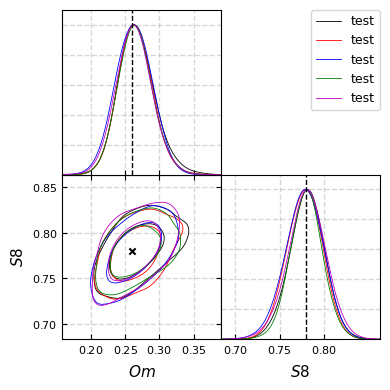

In [20]:
%matplotlib inline 

g = plots.get_subplot_plotter()
g.triangle_plot(gd_samples_list, filled=False)

true = [0.26, 0.78, 0.5]

# add truth values to get subplot
for i in range(2):
    for j in range(2):
        if j > i:
            continue
        ax = g.subplots[i, j]
        if i == j:
            ax.axvline(true[i], color="black", ls="--", lw=1)
        else:
            ax.scatter(true[j], true[i], color="black", marker="x", s=20) 
        ax.grid(True, ls="--", lw=1, alpha=0.5)

In [21]:
cov_mat_list = []

for i in range(len(gd_samples_list)):
    cov_mat_list.append(gd_samples_list[i].getCovMat().matrix)
    
FoM_list = []
for i in range(len(gd_samples_list)):
    FoM_list.append(1./np.sqrt(np.linalg.det(cov_mat_list[i])))
    print(f'FoM in test {i} is {FoM_list[i]}')
    
FoM_list = np.array(FoM_list)

print('mean FoM is ', np.mean(FoM_list))

FoM in test 0 is 2123.0696240698703
FoM in test 1 is 2171.620186272935
FoM in test 2 is 2107.4701092905307
FoM in test 3 is 2362.4250603993337
FoM in test 4 is 2020.6449361337513
mean FoM is  2157.045983233284
